In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.generator.generator import Generator

In [3]:
gen = Generator("https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl")

In [4]:
from PIL import Image
from src.face_frame import face_frame_correction

In [5]:
target_pil = Image.open("/app/ref.png")
target_pil = target_pil.convert('RGB')
output = Image.open("/app/ref.png")
output = output.convert('RGB')

In [6]:
import torch
from src.nets.MobileNetV2_unet import MobileNetV2_unet
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [7]:
model = MobileNetV2_unet(None).to(torch.device("cuda"))
state_dict = torch.load('./src/checkpoints/model.pt', map_location='cuda')
model.load_state_dict(state_dict)
model.eval()
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [8]:
target_img = transform(target_pil)
target_img = target_img.unsqueeze(0)
target_img = target_img.to(torch.device("cuda"))
#set requires_grad to True
target_img.requires_grad = True
# Forward Pass
logits = model(target_img)
#target_mask = logits
target_mask = torch.softmax(logits, dim=1)
print(target_mask.requires_grad)

True


In [9]:
output_img = transform(output)
output_img = output_img.unsqueeze(0)
output_img = output_img.to(torch.device("cuda"))
#set requires_grad to True
output_img.requires_grad = True
# Forward Pass
logits = model(output_img)
#target_mask = logits
output_mask = torch.softmax(logits, dim=1)
print(output_mask.requires_grad)

True


In [10]:
image = target_mask.detach().squeeze(0).cpu().numpy()
penalty_matrix = [
    [0.0, 0.2, 0.2],
    [0.2, 0.0, 0.2],
    [0.2, 0.2, 0.0],
]
penalty_matrix = torch.tensor(penalty_matrix).to(torch.device("cuda"))
print(penalty_matrix)
print(image.shape)
#Image.fromarray(np.uint8(image[0]*128), mode='L')

tensor([[0.0000, 0.2000, 0.2000],
        [0.2000, 0.0000, 0.2000],
        [0.2000, 0.2000, 0.0000]], device='cuda:0')
(3, 224, 224)


In [11]:
target_mask = target_mask.squeeze(0)
output_mask = output_mask.squeeze(0)
FACE=2
HAIR=1
BACKGROUND=0
diff = torch.abs(target_mask - output_mask)
#downscale  face and hair differenc to 0.2
diff[FACE] = diff[FACE] * 0.2
diff[HAIR] = diff[HAIR] * 0.2
dist = torch.sum(diff)
dist.backward()



In [25]:
output, logits = face_frame_correction(target_pil, None, gen.G, gen.device)

step    1/100: dist 3228576.75 loss 3228576.75
torch.Size([1, 3, 224, 224])
step    2/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    3/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    4/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    5/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    6/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    7/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    8/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step    9/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   10/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   11/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   12/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   13/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   14/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   15/100: dist nan  loss nan  
torch.Size([1, 3, 224, 224])
step   16/100:

KeyboardInterrupt: 

In [ ]:
ws = face_frame_correction(target_pil, None, gen.G, gen.device)

RuntimeError: The size of tensor a (224) must match the size of tensor b (0) at non-singleton dimension 3

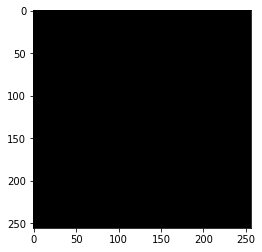

In [61]:
import matplotlib.pyplot as plt
import torch
_w = ws[-1].unsqueeze(0)
img = gen.G.synthesis(_w, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 +
                    128).clamp(0, 255).to(torch.uint8)
img = img[0].cpu().numpy()
plt.imshow(img)

In [ ]:
import torch
import matplotlib.pyplot as plt
for w in ws[-10:-8]:
    _w = w.unsqueeze(0)
    image = gen.G.synthesis(_w, noise_mode='const')
    image = (image.permute(0, 2, 3, 1) * 127.5 +
                    128).clamp(0, 255).to(torch.uint8)
    image = image[0].cpu().numpy()
    image = Image.fromarray(image)
    plt.imshow(image)

KeyError: (100.0, 0.0, '100', 'black', 'top', 'center', 521901957532262403, None, None, False, 72.0, <weakref at 0x7fb59d8a74a0; dead>, 1.2)

<Figure size 432x288 with 1 Axes>

In [ ]:

# for i, image in enumerate(images):
#     image.save(f"/app/out{i}.png")

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

In [ ]:
# avg_latent =  gen.G.mapping.w_avg.unsqueeze(0).repeat(1, gen.G.num_ws, 1)
# N=10
# W = 5
# H = 2
# for feature in range(gen.G.num_ws):
#     plt.figure(feature, figsize=(W*3, H*3))
#     plt.title(f"Feature {feature}")
#     for i in range(N):
#         delta = np.zeros(avg_latent.shape)
#         delta[:, feature, :] = np.random.randn(*delta[:, 0, :].shape)*1.5
#         w = avg_latent + torch.from_numpy(delta).to(gen.device)
#         plt.subplot(H, W, i+1)
#         plt.axis('off')
#         image = gen.G.synthesis(w)
#         image = (image.permute(0, 2, 3, 1) * 127.5 +
#                     128).clamp(0, 255).to(torch.uint8)
#         image = image[0].cpu().numpy()

#         plt.imshow(image)
#     plt.savefig(f"/app/feature{feature}.png")
    
